<a href="https://colab.research.google.com/github/fyp5-project/AI-based-Bi-directional-Translation-of-Sign-Language-into-Speech-System/blob/main/KSL_speech_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!
Working directories created/verified.
Model loaded successfully from /content/drive/MyDrive/sign_language_models/best_model.keras
Step 1: Loading CSV data from Google Drive...

Checking for data files in: /content/drive/MyDrive/sign_language_data
Found 3 files in data directory
CSV files found: ['Test.csv', 'Train.csv']
ZIP files found: ['Images.zip']
Using default file: Train.csv
Using default file: Test.csv

Original train columns: ['img_IDS', 'Label']
Original test columns: ['img_IDS']

Standardized train columns: ['img_IDS', 'Label']
Standardized test columns: ['img_IDS']
Missing columns in test_df: ['Label']. Creating them with default value 'Unknown'.

Data Overview:
Training samples: 6249
Testing samples: 2679

Unique classes in training data: ['Church', 'Enough/Satisfied', 'Friend', 'Love', 'Me', 'Mosque', 'Seat', 'Temple', 'You']

Sample training data:
            img_IDS             Label
0 

Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

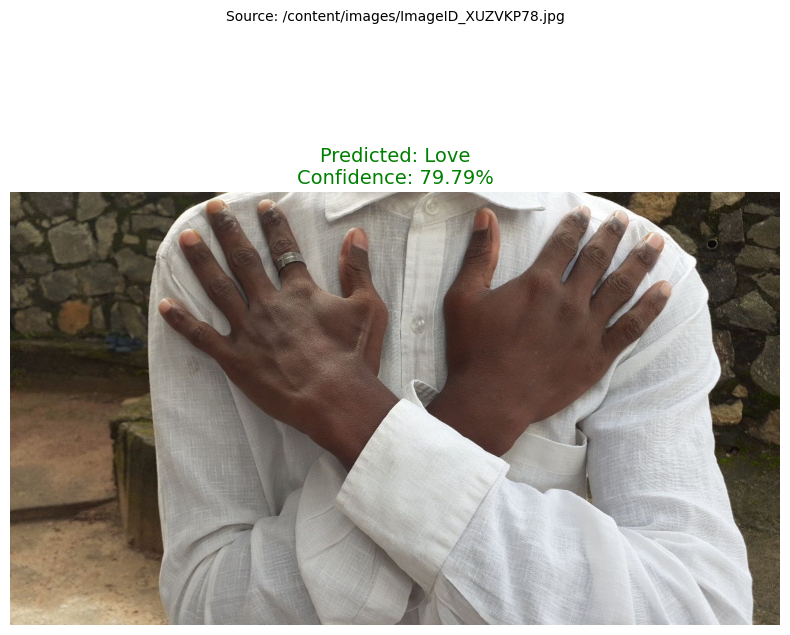

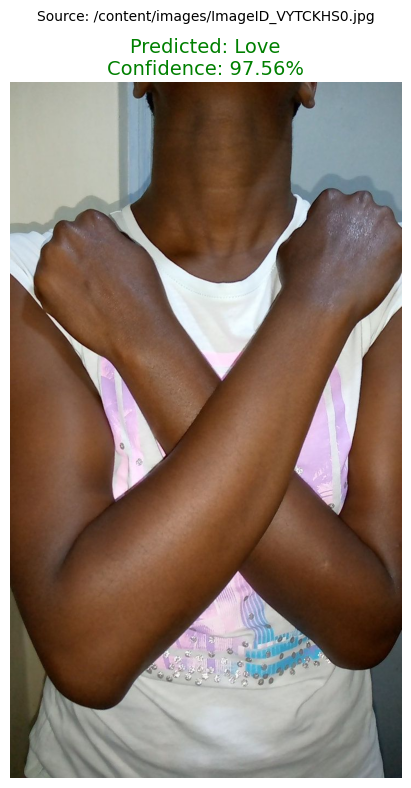

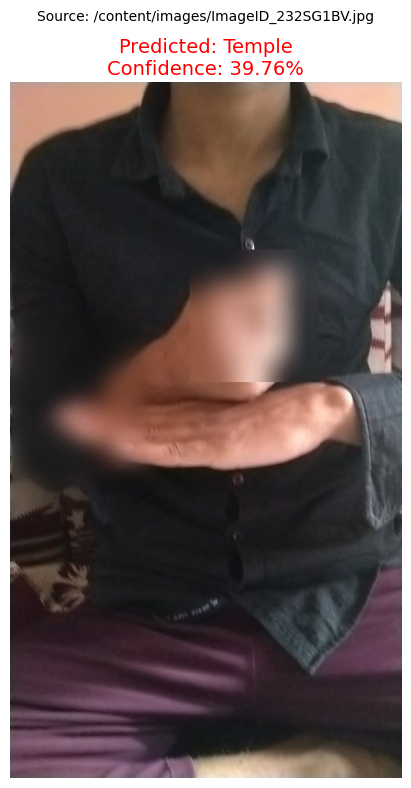

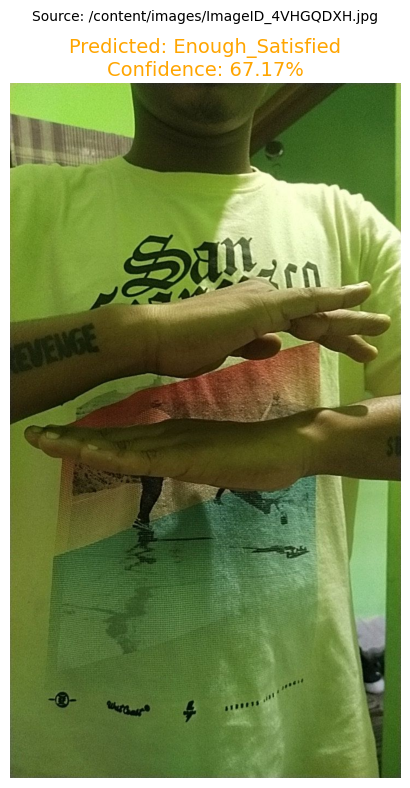

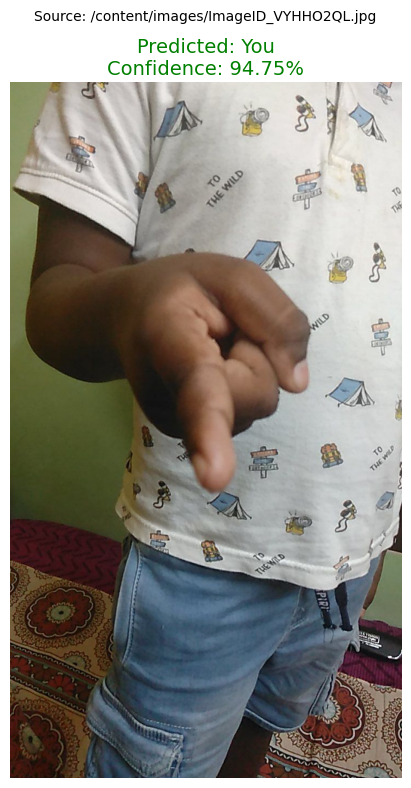


Overall accuracy: 0.00%

Class-wise performance:
           correct      
              mean count
true_label              
Unknown        0.0     5
Found 20 images for test subset
Running batch test on 20 images from test set...

Overall accuracy: 0.00%

Class-wise performance:
           correct      
              mean count
true_label              
Unknown        0.0    20

Top confusion pairs:
  true_label   predicted_label  count
3    Unknown              Love      5
8    Unknown               You      3
4    Unknown                Me      3
6    Unknown              Seat      2
1    Unknown  Enough_Satisfied      2

Sign Language Recognition - Batch Testing Report

Total images tested: 20
Overall accuracy: 0.00%

High confidence predictions (>90%): 6 images, Accuracy: 0.00%
Low confidence predictions (<50%): 2 images, Accuracy: 0.00%

Class-wise Performance:
----------------------
Unknown: 0.00% accuracy (20.0 samples)

Top Confusion Pairs:
-------------------
Unknown → Love: 5

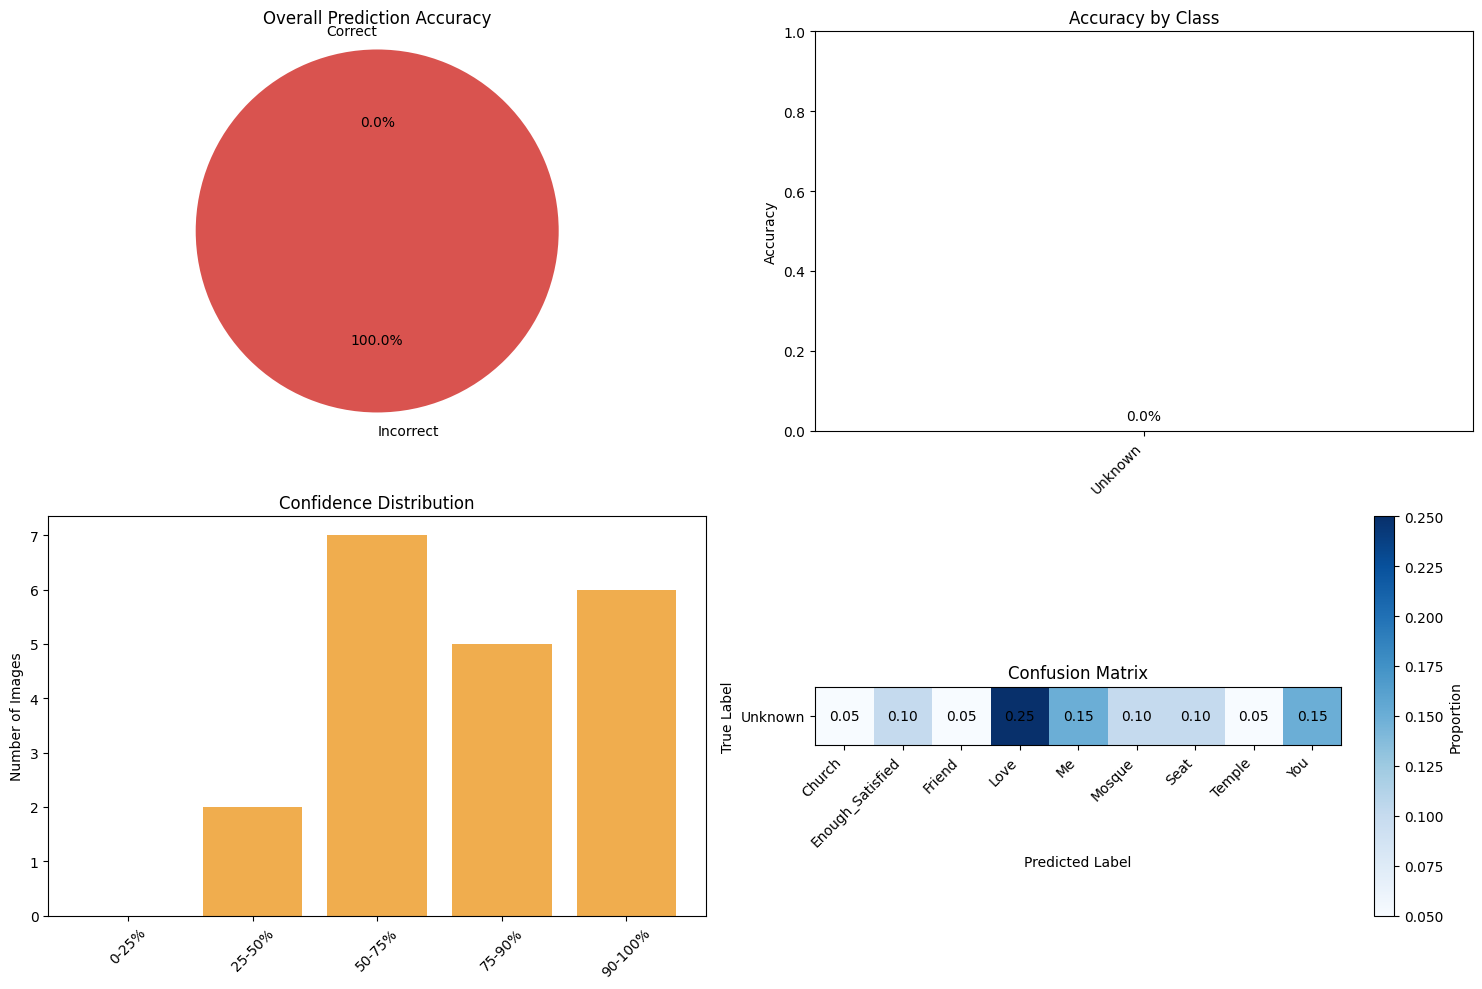

Results exported to: /content/drive/MyDrive/sign_language_results_20250320_202840.csv
Running webcam demo using the Colab webcam capture function.
Running webcam capture...


<IPython.core.display.Javascript object>

MessageError: NotAllowedError: Permission denied

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import os
import shutil
import glob
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from google.colab import drive
from tqdm.notebook import tqdm

from IPython.display import display, Javascript, Audio
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

!pip install gtts
from gtts import gTTS

def text_to_speech(text, lang='en'):
    """
    Convert text to spoken audio using Google Text-to-Speech API, optimized for Colab.

    Args:
        text (str): The text to convert to speech
        lang (str): The language code for the text (default is 'en' for English)
    """
    try:
        # Create TTS object and save to file
        tts = gTTS(text=text, lang=lang, slow=False)
        audio_file = "output.mp3"
        tts.save(audio_file)
        # Play audio in Colab using IPython.display.Audio
        display(Audio(audio_file, autoplay=True))
    except Exception as e:
        print(f"Error converting text to speech: {e}")

# Function to capture webcam image using JavaScript in Colab
def capture_webcam_image(quality=0.8): # Added self as the first parameter
        js = Javascript('''
            async function captureImage(quality) {
                const div = document.createElement('div');
                const video = document.createElement('video');
                const button = document.createElement('button');
                button.innerHTML = 'Capture';
                div.appendChild(video);
                div.appendChild(button);
                document.body.appendChild(div);

                const stream = await navigator.mediaDevices.getUserMedia({video: true});
                video.srcObject = stream;
                await video.play();

                // Wait until the user clicks the capture button.
                await new Promise((resolve) => button.onclick = resolve);

                // Create a canvas element to capture the image.
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);

                // Stop all video streams.
                stream.getTracks().forEach(track => track.stop());
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
            ''')
        display(js)
        data = eval_js("captureImage({})".format(quality))
        header, encoded = data.split(',', 1)
        binary = b64decode(encoded)
        image = Image.open(io.BytesIO(binary))
        return image



# Define the custom preprocessing layer required for loading the model
class PreprocessInputLayer(layers.Layer):
    def __init__(self, name="preprocess_input", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs):
        return tf.keras.applications.resnet50.preprocess_input(inputs)

    def get_config(self):
        return super().get_config()

class GoogleDriveDataHandler:
    def __init__(self, drive_path=None):
        """Initialize the data handler with Google Drive integration

        Args:
            drive_path: Optional custom path to your data folder in Google Drive
        """
        # Mount Google Drive
        self.mount_drive()

        # Set up paths
        self.drive_root = '/content/drive/MyDrive'
        self.data_dir = drive_path if drive_path else os.path.join(self.drive_root, 'sign_language_data')
        self.image_dir = '/content/images'  # Local working directory for extracted images

        # Initialize dataframes
        self.train_df = None
        self.test_df = None

        # Create necessary directories
        self.ensure_directories()

    def mount_drive(self):
        """Mount Google Drive to access files"""
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        print("Google Drive mounted successfully!")

    def ensure_directories(self):
        """Create necessary directories if they don't exist"""
        # Clear existing image directory if it exists to avoid mixed files
        if os.path.exists(self.image_dir):
            shutil.rmtree(self.image_dir)

        os.makedirs(self.image_dir, exist_ok=True)
        # Also create the data directory in Google Drive if it doesn't exist
        os.makedirs(self.data_dir, exist_ok=True)
        print(f"Working directories created/verified.")

    def check_drive_data(self):
        """Check if required files exist in Google Drive"""
        print(f"\nChecking for data files in: {self.data_dir}")

        # List files in the data directory
        try:
            files = os.listdir(self.data_dir)
            print(f"Found {len(files)} files in data directory")

            # Check for CSV files
            csv_files = [f for f in files if f.endswith('.csv')]
            print(f"CSV files found: {csv_files}")

            # Check for zip files
            zip_files = [f for f in files if f.endswith('.zip')]
            print(f"ZIP files found: {zip_files}")

            if not csv_files:
                print("Warning: No CSV files found in data directory")

            if not zip_files:
                print("Warning: No ZIP files found in data directory")

            return files

        except Exception as e:
            print(f"Error accessing data directory: {e}")
            return []

    def select_file(self, file_list, file_type, default_name=None):
        """Let the user select a file from the list or use default"""
        matching_files = [f for f in file_list if f.endswith(file_type)]

        if not matching_files:
            print(f"No {file_type} files found!")
            return None

        # Check if default name exists in the list
        if default_name and default_name in matching_files:
            print(f"Using default file: {default_name}")
            return default_name

        # Let user select from available files
        print(f"\nAvailable {file_type} files:")
        for i, file in enumerate(matching_files):
            print(f"{i+1}. {file}")

        while True:
            try:
                selection = input(f"Select {file_type} file number (or press Enter for first option): ")
                if selection.strip() == "":
                    return matching_files[0]

                index = int(selection) - 1
                if 0 <= index < len(matching_files):
                    return matching_files[index]
                else:
                    print("Invalid selection. Please try again.")
            except ValueError:
                print("Please enter a valid number.")

    def load_csv_data(self):
        """Load CSV data from Google Drive with robust column handling"""
        files = self.check_drive_data()

        # Select train CSV
        train_csv = self.select_file(files, '.csv', 'Train.csv')
        if not train_csv:
            print("Error: Training CSV file not found")
            return False

        # Select test CSV
        test_csv = self.select_file(files, '.csv', 'Test.csv')
        if not test_csv:
            print("Error: Test CSV file not found")
            return False

        try:
            # Load the CSV files
            self.train_df = pd.read_csv(os.path.join(self.data_dir, train_csv))
            self.test_df = pd.read_csv(os.path.join(self.data_dir, test_csv))

            # Print original column names for debugging
            print("\nOriginal train columns:", self.train_df.columns.tolist())
            print("Original test columns:", self.test_df.columns.tolist())

            # Function to standardize column names (case-insensitive)
            def standardize_columns(df):
                column_mapping = {}
                for column in df.columns:
                    col_lower = column.lower().strip()
                    if 'img' in col_lower and 'id' in col_lower:
                        column_mapping[column] = 'img_IDS'
                    elif col_lower == 'label' or col_lower == 'labels':
                        column_mapping[column] = 'Label'
                if column_mapping:
                    df = df.rename(columns=column_mapping)
                return df

            # Apply standardization to both dataframes
            self.train_df = standardize_columns(self.train_df)
            self.test_df = standardize_columns(self.test_df)

            # Print standardized column names
            print("\nStandardized train columns:", self.train_df.columns.tolist())
            print("Standardized test columns:", self.test_df.columns.tolist())

            # Define the required columns
            required_columns = {'img_IDS', 'Label'}

            # Check for missing required columns in both dataframes
            for df_name, df in [('train_df', self.train_df), ('test_df', self.test_df)]:
                df_columns_lower = {col.lower() for col in df.columns}
                missing_columns = [col for col in required_columns if col.lower() not in df_columns_lower]
                if missing_columns:
                    print(f"Missing columns in {df_name}: {missing_columns}. Creating them with default value 'Unknown'.")
                    for col in missing_columns:
                        df[col] = "Unknown"

            # Create a column mapping based on the training dataframe for case-insensitive access
            self.column_map = {col.lower(): col for col in self.train_df.columns}

            print("\nData Overview:")
            print(f"Training samples: {len(self.train_df)}")
            print(f"Testing samples: {len(self.test_df)}")

            # Get the actual Label column name safely
            label_col = self.get_column_name('label')
            if label_col:
                print("\nUnique classes in training data:", sorted(self.train_df[label_col].unique()))

            # Display sample data
            print("\nSample training data:")
            print(self.train_df.head())

            return True

        except Exception as e:
            print(f"Error loading CSV data: {e}")
            import traceback
            traceback.print_exc()
            return False


    def get_column_name(self, column):
        """Get the actual column name regardless of case"""
        if column.lower() in self.column_map:
            return self.column_map[column.lower()]
        return None

    def fast_unzip(self, zip_path, num_workers=4):
        """Efficiently unzip files using parallel processing"""
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # Get list of all files
                all_members = zip_ref.namelist()
                total_files = len(all_members)

                if total_files == 0:
                    print("Error: Empty zip file")
                    return False

                print(f"\nExtracting {total_files} files...")

                # Check for folder structure in the zip
                has_folders = any('/' in member for member in all_members)
                if has_folders:
                    print("Detected folder structure in ZIP file")

                # Calculate chunk size for each worker
                chunk_size = max(1, total_files // num_workers)
                chunks = [all_members[i:i + chunk_size]
                         for i in range(0, total_files, chunk_size)]

                # Extract files
                zip_ref.extractall(self.image_dir)
                print("Extraction complete!")

                # If the zip has a folder structure, find and move all images to the main folder
                if has_folders:
                    self.flatten_directory()

                return True

        except Exception as e:
            print(f"Error processing zip file: {e}")
            return False

    def flatten_directory(self):
        """Move all image files from subdirectories to the main image directory"""
        print("Flattening directory structure...")

        # Find all image files in subdirectories
        image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
        image_files = []

        for ext in image_extensions:
            image_files.extend(glob.glob(f"{self.image_dir}/**/*{ext}", recursive=True))

        # Move them to the main directory
        moved_count = 0
        for img_path in image_files:
            if os.path.dirname(img_path) != self.image_dir:
                filename = os.path.basename(img_path)
                dest_path = os.path.join(self.image_dir, filename)

                # Handle duplicate filenames by appending a number
                if os.path.exists(dest_path):
                    base, ext = os.path.splitext(filename)
                    i = 1
                    while os.path.exists(os.path.join(self.image_dir, f"{base}_{i}{ext}")):
                        i += 1
                    dest_path = os.path.join(self.image_dir, f"{base}_{i}{ext}")

                shutil.move(img_path, dest_path)
                moved_count += 1

        print(f"Moved {moved_count} images to the main directory")

    def extract_images(self):
        """Extract images from Google Drive zip file"""
        files = self.check_drive_data()

        # Select zip file
        zip_file = self.select_file(files, '.zip')
        if not zip_file:
            print("Error: No zip file found")
            return False

        # Full path to zip file
        zip_path = os.path.join(self.data_dir, zip_file)

        print(f"\nExtracting images from {zip_file}...")
        return self.fast_unzip(zip_path)

    def verify_images(self):
        """Verify that all required images are present"""
        if not os.path.exists(self.image_dir):
            print("Error: Image directory not found")
            return False

        # Use glob to find all image files in top level and subdirectories
        image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
        image_files = []

        for ext in image_extensions:
            found_files = glob.glob(f"{self.image_dir}/*{ext}")
            image_files.extend([os.path.basename(f) for f in found_files])

        if not image_files:
            # Try finding without extension filter - maybe there are images without extensions
            all_files = os.listdir(self.image_dir)
            print(f"No standard image files found. Directory contains {len(all_files)} files.")
            print(f"Sample files: {all_files[:10]}")

            # Try examining all the files in detail
            if all_files:
                print("\nDetailed file listing:")
                img_dir_contents = glob.glob(f"{self.image_dir}/**", recursive=True)
                for item in img_dir_contents[:20]:  # Show first 20 items
                    if os.path.isdir(item):
                        print(f"DIR: {item}")
                    else:
                        print(f"FILE: {item} ({os.path.getsize(item)} bytes)")
            return False

        # Check if number of images matches CSV entries
        expected_count = len(self.train_df) + len(self.test_df)
        actual_count = len(image_files)

        print(f"\nVerification Results:")
        print(f"Expected images: approximately {expected_count}")
        print(f"Actual images found: {actual_count}")

        # Check if we have enough images to proceed
        if actual_count < expected_count * 0.9:  # Allow some flexibility (90%)
            print("Warning: Significantly fewer images than expected")
            print("This may indicate an issue with the extraction process or mismatched file names")

        # Sample image format check and confirmation
        sample_images = image_files[:5]
        formats = [os.path.splitext(img)[1] for img in sample_images if os.path.splitext(img)[1]]

        if not formats:
            print("Error: Could not detect image format")
            # Check for image files without extensions
            print("Checking for files without extensions...")
            for f in sample_images:
                if not os.path.splitext(f)[1]:
                    full_path = os.path.join(self.image_dir, f)
                    print(f"File without extension: {f} ({os.path.getsize(full_path)} bytes)")
            return False

        most_common_format = max(set(formats), key=formats.count)
        print(f"Detected image format: {most_common_format}")
        print(f"Sample image names: {sample_images}")

        # Check if images exist for some sample IDs from the dataframe
        if self.train_df is not None:
            sample_ids = self.train_df['img_IDS'].head(3).tolist()
            print("\nChecking for existence of sample images:")
            for img_id in sample_ids:
                found = False
                # Try multiple potential filename patterns
                patterns = [
                    f"{img_id}{most_common_format}",  # Exact match with detected format
                    f"{img_id.lower()}{most_common_format}",  # Lowercase with detected format
                    f"{img_id}.*",  # Any extension
                ]

                for pattern in patterns:
                    matches = glob.glob(os.path.join(self.image_dir, pattern))
                    if matches:
                        print(f"  {img_id}: Found as {os.path.basename(matches[0])}")
                        found = True
                        break

                if not found:
                    print(f"  {img_id}: Not found with any expected pattern")
                    # Find all files that contain the ID as a substring
                    potential_matches = [f for f in image_files if img_id.lower() in f.lower()]
                    if potential_matches:
                        print(f"    But found similar files: {potential_matches[:3]}")

        return True

    def process_data(self):
        """Main method to handle the entire data processing pipeline"""
        print("Step 1: Loading CSV data from Google Drive...")
        if not self.load_csv_data():
            return False

        print("\nStep 2: Extracting images from zip file...")
        if not self.extract_images():
            return False

        print("\nStep 3: Verifying image files...")
        if not self.verify_images():
            print("\nWarning: Verification found issues, but we'll continue.")

        # If verification failed but files exist, we'll continue anyway
        image_count = len(glob.glob(f"{self.image_dir}/*.*"))
        if image_count > 0:
            print(f"\nFound {image_count} files in the image directory. Continuing...")
            return True
        else:
            print("\nNo usable image files found. Cannot proceed.")
            return False

    def get_image_format(self):
        """Determine the image format after extraction"""
        # Look for common image file extensions
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
            matches = glob.glob(f"{self.image_dir}/*{ext}")
            if matches:
                return ext

        # If no standard extensions found, examine some files
        files = os.listdir(self.image_dir)
        if not files:
            return None

        # Try to determine extension from first few files
        for f in files[:10]:
            ext = os.path.splitext(f)[1]
            if ext:
                return ext

        # If still no extension, return placeholder
        return '.unknown'

    def get_image_paths(self, subset='all', limit=None):
        """Get paths to images based on subset type with robust column handling"""
        if subset == 'train' and self.train_df is not None:
            df = self.train_df
        elif subset == 'test' and self.test_df is not None:
            df = self.test_df
        elif subset == 'all' and self.train_df is not None and self.test_df is not None:
            df = pd.concat([self.train_df, self.test_df])
        else:
            print(f"Error: Invalid subset '{subset}' or missing dataframes")
            return []

        # Limit the dataframe if requested
        if limit is not None and limit > 0:
            df = df.head(limit)

        # Get the image format
        img_format = self.get_image_format()
        if not img_format:
            print("Error: Cannot determine image format")
            return []

        # Get the actual column names regardless of case
        img_id_col = self.get_column_name('img_ids')
        label_col = self.get_column_name('label')

        if not img_id_col or not label_col:
            print(f"Error: Required columns not found. Available columns: {df.columns.tolist()}")
            return []

        # Build paths and pair with labels
        image_data = []
        for _, row in df.iterrows():
            img_id = row[img_id_col]
            label = row[label_col]

            # Try different filename patterns
            filename_patterns = [
                f"{img_id}{img_format}",
                f"{img_id.lower()}{img_format}",
                f"{img_id}.*"
            ]

            found = False
            for pattern in filename_patterns:
                matches = glob.glob(os.path.join(self.image_dir, pattern))
                if matches:
                    image_data.append((matches[0], label))
                    found = True
                    break

            if not found:
                print(f"Warning: Image not found for ID {img_id}")

        print(f"Found {len(image_data)} images for {subset} subset")
        return image_data





class SignLanguageRecognizer:
    def __init__(self, model_path, class_names=None):
        """
        Initialize the sign language recognizer.

        Args:
            model_path (str): Path to the trained model file
            class_names (list): List of class names corresponding to model outputs
        """
        self.model_path = model_path
        self.model = None

        # Default class names for the model
        self.default_classes = [
            'Church', 'Enough_Satisfied', 'Friend', 'Love',
            'Me', 'Mosque', 'Seat', 'Temple', 'You'
        ]

        # Use provided class names or default ones
        self.class_names = class_names if class_names else self.default_classes

        # Load the model
        self._load_model()

    def _load_model(self):
        """Load the trained model with custom layer handling."""
        try:
            # This allows loading PreprocessInputLayer and preprocess_input
            self.model = tf.keras.models.load_model(
                self.model_path,
                custom_objects={
                    'PreprocessInputLayer': PreprocessInputLayer,
                    "preprocess_input": tf.keras.applications.resnet50.preprocess_input
                }
            )
            print(f"Model loaded successfully from {self.model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise


    def preprocess_image(self, img):
        """
        Preprocess an image for model prediction.

        Args:
            img (numpy.ndarray): Input image in BGR format

        Returns:
            numpy.ndarray: Preprocessed image ready for model input
        """
        # Resize to expected dimensions
        img = cv2.resize(img, (224, 224))

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Add batch dimension
        img = np.expand_dims(img, axis=0)

        # Apply ResNet50 preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)

        return img




    def predict_from_file(self, image_path, display_result=False, speak =True):
        """
        Predict sign language from an image file.

        Args:
            image_path (str): Path to the image file
            display_result (bool): Whether to display the result with matplotlib
            speak(bool): whether to speak the predicted label (default True)

        Returns:
            dict: Prediction result containing label, confidence, and index
        """

        '''if not os.path.exists(image_path):
            print(f"Error: Image file not found at {image_path}")
            return None

        try:
            # Read image
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Could not read image at {image_path}")
                return None

            return self.predict_from_array(img, image_path, display_result)

        except Exception as e:
            print(f"Error during prediction: {e}")
            return None'''

        result = self._predict(image_path)
        if result:
            if speak:
                text_to_speech(result['label'])
            if display_result:
                self._display_prediction(cv2.imread(image_path), result, image_path)
        return result

    def _predict(self, image_path):
        """Helper method to avoid code duplication."""
        if not os.path.exists(image_path):
            print(f"Error: Image file not found at {image_path}")
            return None
        try:
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Could not read image at {image_path}")
                return None
            return self.predict_from_array(img, image_path)
        except Exception as e:
            print(f"Error during prediction: {e}")
            return None

    def predict_from_array(self, img_array, image_source="Image", display_result=False):
        """
        Predict sign language from a numpy image array.

        Args:
            img_array (numpy.ndarray): Image as numpy array in BGR format
            image_source (str): Description of image source for display
            display_result (bool): Whether to display the result with matplotlib

        Returns:
            dict: Prediction result containing label, confidence, and index
        """
        try:
            # Keep original for display
            original_img = img_array.copy()

            # Preprocess image
            processed_img = self.preprocess_image(img_array)

            # Make prediction
            prediction = self.model.predict(processed_img, verbose=0)

            # Get most likely class and its probability
            label_idx = np.argmax(prediction[0])
            confidence = float(prediction[0][label_idx])
            predicted_label = self.class_names[label_idx]

            result = {
                'label': predicted_label,
                'confidence': confidence,
                'index': label_idx
            }

            # Display result if requested
            if display_result:
                self._display_prediction(original_img, result, image_source)

            return result

        except Exception as e:
            print(f"Error during prediction: {e}")
            return None

    def _display_prediction(self, img, result, source):
        """Display the prediction result with the image."""
        plt.figure(figsize=(8, 8))

        # Convert BGR to RGB for display
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)

        # Format title with prediction info
        title = f"Predicted: {result['label']}\n"
        title += f"Confidence: {result['confidence']:.2%}"

        # Set color based on confidence
        color = 'green' if result['confidence'] > 0.7 else 'orange' if result['confidence'] > 0.5 else 'red'

        plt.title(title, color=color, fontsize=14)
        plt.suptitle(f"Source: {source}", fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    '''
    def batch_predict(self, image_list, true_labels=None, display_results=False, limit=None):
        """
        Run predictions on a batch of images.

        Args:
            image_list: List of image paths or (path, label) tuples
            true_labels: List of true labels (optional, if not included in image_list)
            display_results: Whether to display images with predictions
            speak: whether to speak the predicted label (default False)
            limit: Maximum number of images to process (None for all)

        Returns:
            DataFrame with prediction results
        """

        results = []

        # Process the image_list to handle both formats
        if image_list and isinstance(image_list[0], tuple):
            # List contains (path, label) tuples
            paths_and_labels = image_list
        else:
            # List contains only paths, pair with labels if provided
            if true_labels and len(true_labels) == len(image_list):
                paths_and_labels = list(zip(image_list, true_labels))
            else:
                # No labels or mismatched lengths
                paths_and_labels = [(path, None) for path in image_list]

        # Limit the number of images if requested
        if limit is not None and limit > 0:
            paths_and_labels = paths_and_labels[:limit]

        # Process each image
        print(f"Processing {len(paths_and_labels)} images...")
        for i, (path, true_label) in enumerate(tqdm(paths_and_labels)):
            # Check if the path exists
            if not os.path.exists(path):
                print(f"Image not found: {path}")
                continue

            # Predict from this image
            prediction = self.predict_from_file(path, display_result=display_results)

            if prediction:
                # Add to results
                result_entry = {
                    'image_path': path,
                    'file_name': os.path.basename(path),
                    'predicted_label': prediction['label'],
                    'confidence': prediction['confidence'],
                    'true_label': true_label
                }

                # Add a correctness flag if we have a true label
                if true_label is not None:
                    result_entry['correct'] = (prediction['label'] == true_label)

                results.append(result_entry)

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)

        # Calculate accuracy if true labels were provided
        if 'correct' in results_df.columns:
            accuracy = results_df['correct'].mean()
            print(f"\nOverall accuracy: {accuracy:.2%}")

            # Class-wise accuracy
            if len(results_df) > 0:
                print("\nClass-wise performance:")
                class_metrics = results_df.groupby('true_label').agg({
                    'correct': ['mean', 'count']
                })
                print(class_metrics)

                # Confusion matrix
                if len(results_df) >= 10:  # Only if we have enough samples
                    print("\nTop confusion pairs:")
                    confusion = results_df[~results_df['correct']].groupby(
                        ['true_label', 'predicted_label']).size().reset_index(name='count')
                    confusion = confusion.sort_values('count', ascending=False).head(5)
                    print(confusion)

        return results_df


        results = []
        paths_and_labels = [(path, None) if isinstance(path, str) else path for path in image_list]
        if true_labels and len(true_labels) == len(image_list):
            paths_and_labels = list(zip(image_list, true_labels))
        if limit:
            paths_and_labels = paths_and_labels[:limit]

        print(f"Processing {len(paths_and_labels)} images...")
        for path, true_label in tqdm(paths_and_labels):
            if not os.path.exists(path):
                print(f"Image not found: {path}")
                continue
            result = self.predict_from_file(path, display_result=display_results, speak=speak)
            if result:
                entry = {
                    'image_path': path,
                    'file_name': os.path.basename(path),
                    'predicted_label': result['label'],
                    'confidence': result['confidence'],
                    'true_label': true_label,
                    'correct': result['label'] == true_label if true_label else None
                }
                results.append(entry)
        return pd.DataFrame(results)


    def batch_predict(self, image_list, true_labels=None, display_results=False, speak=False, limit=None):
        paths = [(path if isinstance(path, str) else path[0]) for path in image_list[:limit]]
        labels = true_labels or ([path[1] if isinstance(path, tuple) else None for path in image_list[:limit]])

        def load_and_preprocess(path):
            img = tf.io.read_file(path)
            img = tf.image.decode_image(img, channels=3)
            img.set_shape([None, None, 3])
            img = tf.image.resize(img, [224, 224])
            return tf.keras.applications.resnet50.preprocess_input(img)

        dataset = tf.data.Dataset.from_tensor_slices(paths).map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32)
        predictions = self.model.predict(dataset, verbose=0)

        results = []
        for i, (path, pred) in enumerate(zip(paths, predictions)):
            label_idx = np.argmax(pred)
            result = {
                'image_path': path,
                'file_name': os.path.basename(path),
                'predicted_label': self.class_names[label_idx],
                'confidence': float(pred[label_idx]),
                'true_label': labels[i],
                'correct': self.class_names[label_idx] == labels[i] if labels[i] else None
            }
            if speak:
                text_to_speech(result['predicted_label'])
            if display_results:
                self._display_prediction(cv2.imread(path), result, path)
            results.append(result)
        return pd.DataFrame(results) '''



    def batch_predict(self, image_list, true_labels=None, display_results=False, speak=False, limit=None):
        """
        Run predictions on a batch of images.

        Args:
            image_list: List of image paths or (path, label) tuples.
            true_labels: List of true labels (optional, if not included in image_list).
            display_results: Whether to display images with predictions.
            speak: Whether to speak the predicted label (default False).
            limit: Maximum number of images to process (None for all).

        Returns:
            DataFrame with prediction results.
        """

        results = []

        # Normalize image_list into a list of (path, label) tuples.
        if image_list and isinstance(image_list[0], tuple):
            # Already in (path, label) format.
            paths_and_labels = image_list
        else:
            if true_labels and len(true_labels) == len(image_list):
                paths_and_labels = list(zip(image_list, true_labels))
            else:
                # No labels provided or mismatched lengths.
                paths_and_labels = [(path, None) for path in image_list]

        # Apply limit if given.
        if limit is not None and limit > 0:
            paths_and_labels = paths_and_labels[:limit]

        # Decide which mode to use: batch prediction vs. individual processing.
        # We use batch mode only if we're not displaying/speaking, which allows for faster processing.
        if not display_results and not speak:
            # Batch processing using tf.data.Dataset.
            paths = [path for (path, _) in paths_and_labels]
            labels = [label for (_, label) in paths_and_labels]

            def load_and_preprocess(path):
                # Read the image file.
                img = tf.io.read_file(path)
                img = tf.image.decode_image(img, channels=3)
                # Set static shape.
                img.set_shape([None, None, 3])
                # Resize to match model's input.
                img = tf.image.resize(img, [224, 224])
                # Preprocess according to ResNet50 requirements.
                return tf.keras.applications.resnet50.preprocess_input(img)

            dataset = tf.data.Dataset.from_tensor_slices(paths)
            dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

            predictions = self.model.predict(dataset, verbose=0)

            # Process each prediction.
            for i, (path, pred) in enumerate(zip(paths, predictions)):
                label_idx = np.argmax(pred)
                pred_label = self.class_names[label_idx]
                result = {
                    'image_path': path,
                    'file_name': os.path.basename(path),
                    # Both keys are provided for compatibility.
                    'label': pred_label,
                    'predicted_label': pred_label,
                    'confidence': float(pred[label_idx]),
                    'true_label': labels[i],
                    'correct': pred_label == labels[i] if labels[i] is not None else None
                }
                if speak:
                    text_to_speech(pred_label)
                results.append(result)
        else:
            # Individual processing for display/speak mode.
            for (path, true_label) in tqdm(paths_and_labels, desc="Processing images"):
                # Verify that the image file exists.
                if not os.path.exists(path):
                    print(f"Image not found: {path}")
                    continue

                # Use an existing helper to predict from a file.
                prediction = self.predict_from_file(path, display_result=display_results)
                if not prediction:
                    continue

                result = {
                    'image_path': path,
                    'file_name': os.path.basename(path),
                    # Ensure key 'label' is used so that _display_prediction finds it.
                    'label': prediction['label'],
                    'predicted_label': prediction['label'],
                    'confidence': prediction['confidence'],
                    'true_label': true_label,
                    'correct': prediction['label'] == true_label if true_label is not None else None
                }
                if speak:
                    text_to_speech(prediction['label'])
                results.append(result)

        results_df = pd.DataFrame(results)

        # Calculate and print accuracy if true labels are provided.
        if not results_df.empty and 'correct' in results_df.columns:
            accuracy = results_df['correct'].mean()
            print(f"\nOverall accuracy: {accuracy:.2%}")

            # Optional: Print class-wise performance if available.
            print("\nClass-wise performance:")
            class_metrics = results_df.groupby('true_label').agg({
                'correct': ['mean', 'count']
            })
            print(class_metrics)

            # Optional: Display confusion matrix if enough samples exist.
            if len(results_df) >= 10:
                print("\nTop confusion pairs:")
                confusion = results_df[~results_df['correct']].groupby(
                    ['true_label', 'predicted_label']).size().reset_index(name='count')
                confusion = confusion.sort_values('count', ascending=False).head(5)
                print(confusion)

        return results_df


class SignLanguageBatchTester:
    """Combines data handling and model prediction for batch testing"""

    def __init__(self, model_path, drive_path=None, class_names=None):
        """
        Initialize the batch tester.

        Args:
            model_path: Path to the trained model file
            drive_path: Optional custom path to data folder in Google Drive
            class_names: List of class names for the model
        """
        # Initialize the data handler
        self.data_handler = GoogleDriveDataHandler(drive_path)

        # Initialize the recognizer
        self.recognizer = SignLanguageRecognizer(model_path, class_names)

        # Store class names from the recognizer for convenience
        self.class_names = self.recognizer.class_names

    def process_data(self):
        """Process the data using the data handler"""
        return self.data_handler.process_data()

    def run_batch_test(self, subset='test', limit=50, display_results=False):
        """
        Run batch prediction on a subset of images.

        Args:
            subset: Which dataset to use ('train', 'test', or 'all')
            limit: Maximum number of images to process
            display_results: Whether to display prediction results

        Returns:
            DataFrame with prediction results
        """
        # Get image paths with labels
        image_data = self.data_handler.get_image_paths(subset, limit)

        if not image_data:
            print("No images found to test. Make sure data is processed first.")
            return None

        # Run batch prediction
        print(f"Running batch test on {len(image_data)} images from {subset} set...")
        return self.recognizer.batch_predict(image_data, display_results=display_results)



    def run_sample_test(self, n_samples=5, display_results=True, speak =True):
        """
        Run a quick test on a few sample images.

        Args:
            n_samples: Number of random samples to test
            display_results: Whether to display prediction results
        """
        # Get a few test images
        test_images = self.data_handler.get_image_paths('test')

        if not test_images:
            print("No test images found. Make sure data is processed first.")
            return None

        # Take random samples
        if n_samples < len(test_images):
            import random
            samples = random.sample(test_images, n_samples)
        else:
            samples = test_images[:n_samples]

        # Run predictions and display results
        return self.recognizer.batch_predict(samples, display_results=display_results)



    def generate_summary_report(self, results_df):
        """
        Generate a summary report from batch prediction results.

        Args:
            results_df: DataFrame with prediction results

        Returns:
            String with formatted report
        """
        if results_df is None or len(results_df) == 0:
            return "No results to summarize."

        # Overall statistics
        total_images = len(results_df)

        report = f"Sign Language Recognition - Batch Testing Report\n"
        report += f"===============================================\n\n"
        report += f"Total images tested: {total_images}\n"

        # Accuracy stats if we have true labels
        if 'correct' in results_df.columns:
            accuracy = results_df['correct'].mean()
            report += f"Overall accuracy: {accuracy:.2%}\n\n"

            # High confidence predictions
            high_conf = results_df[results_df['confidence'] > 0.9]
            high_conf_acc = high_conf['correct'].mean() if len(high_conf) > 0 else 0
            report += f"High confidence predictions (>90%): {len(high_conf)} images, Accuracy: {high_conf_acc:.2%}\n"

            # Low confidence predictions
            low_conf = results_df[results_df['confidence'] < 0.5]
            low_conf_acc = low_conf['correct'].mean() if len(low_conf) > 0 else 0
            report += f"Low confidence predictions (<50%): {len(low_conf)} images, Accuracy: {low_conf_acc:.2%}\n\n"

            # Class-wise performance
            report += "Class-wise Performance:\n"
            report += "----------------------\n"

            class_metrics = results_df.groupby('true_label').agg({
                'correct': ['mean', 'count']
            })

            for idx, row in class_metrics.iterrows():
                accuracy = row[('correct', 'mean')]
                count = row[('correct', 'count')]
                report += f"{idx}: {accuracy:.2%} accuracy ({count} samples)\n"

            # Top confusion pairs
            if len(results_df) >= 10:
                report += "\nTop Confusion Pairs:\n"
                report += "-------------------\n"
                confusion = results_df[~results_df['correct']].groupby(
                    ['true_label', 'predicted_label']).size().reset_index(name='count')
                confusion = confusion.sort_values('count', ascending=False).head(5)

                if not confusion.empty:
                    for _, row in confusion.iterrows():
                        report += f"{row['true_label']} → {row['predicted_label']}: {row['count']} instances\n"
                else:
                    report += "No confusion pairs found (all predictions correct)\n"

        # Confidence distribution
        report += "\nConfidence Distribution:\n"
        report += "----------------------\n"

        # Create confidence bins
        bins = [0, 0.25, 0.5, 0.75, 0.9, 1.0]
        bin_labels = ["0-25%", "25-50%", "50-75%", "75-90%", "90-100%"]
        results_df['conf_bin'] = pd.cut(results_df['confidence'], bins=bins, labels=bin_labels)

        bin_counts = results_df['conf_bin'].value_counts().sort_index()
        for bin_label, count in bin_counts.items():
            percentage = count / total_images * 100
            report += f"{bin_label}: {count} images ({percentage:.1f}%)\n"

        return report

    def visualize_results(self, results_df):
        """
        Create visualizations for the prediction results.

        Args:
            results_df: DataFrame with prediction results
        """
        if results_df is None or len(results_df) == 0:
            print("No results to visualize.")
            return

        # Set up the figure with multiple subplots
        fig = plt.figure(figsize=(15, 10))

        # 1. Overall accuracy if true labels are available
        if 'correct' in results_df.columns:
            plt.subplot(2, 2, 1)
            accuracy = results_df['correct'].mean()

            # Create a simple pie chart for overall accuracy
            labels = ['Correct', 'Incorrect']
            sizes = [accuracy, 1-accuracy]
            colors = ['#5cb85c', '#d9534f']
            plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            plt.axis('equal')
            plt.title('Overall Prediction Accuracy')

            # 2. Class-wise accuracy
            plt.subplot(2, 2, 2)
            class_metrics = results_df.groupby('true_label')['correct'].mean().sort_values(ascending=False)

            bars = plt.bar(class_metrics.index, class_metrics.values, color='#5bc0de')
            plt.title('Accuracy by Class')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45, ha='right')
            plt.ylim(0, 1.0)

            # Add value labels on top of bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                        f'{height:.1%}', ha='center', va='bottom')

        # 3. Confidence distribution
        plt.subplot(2, 2, 3)

        # Create confidence bins if not already created
        if 'conf_bin' not in results_df.columns:
            bins = [0, 0.25, 0.5, 0.75, 0.9, 1.0]
            bin_labels = ["0-25%", "25-50%", "50-75%", "75-90%", "90-100%"]
            results_df['conf_bin'] = pd.cut(results_df['confidence'], bins=bins, labels=bin_labels)

        bin_counts = results_df['conf_bin'].value_counts().sort_index()
        plt.bar(bin_counts.index, bin_counts.values, color='#f0ad4e')
        plt.title('Confidence Distribution')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)

        # 4. Confusion matrix (heatmap) if we have enough data
        if 'correct' in results_df.columns and len(results_df) >= 10:
            plt.subplot(2, 2, 4)

            confusion_matrix = pd.crosstab(
                results_df['true_label'],
                results_df['predicted_label'],
                normalize='index'  # Normalize by row (true labels)
            )

            plt.imshow(confusion_matrix, cmap='Blues')
            plt.colorbar(label='Proportion')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')

            # Add class labels
            plt.xticks(range(len(confusion_matrix.columns)), confusion_matrix.columns, rotation=45, ha='right')
            plt.yticks(range(len(confusion_matrix.index)), confusion_matrix.index)

            # Add text annotations in the cells
            for i in range(len(confusion_matrix.index)):
                for j in range(len(confusion_matrix.columns)):
                    text = f'{confusion_matrix.iloc[i, j]:.2f}' if confusion_matrix.iloc[i, j] > 0 else ''
                    plt.text(j, i, text, ha='center', va='center',
                          color='white' if confusion_matrix.iloc[i, j] > 0.5 else 'black')

        plt.tight_layout()
        plt.show()

    def export_results(self, results_df, export_path=None):
        """
        Export the prediction results to a CSV file.

        Args:
            results_df: DataFrame with prediction results
            export_path: Path to save the CSV file (default: Google Drive)

        Returns:
            Path to the exported file
        """
        if results_df is None or len(results_df) == 0:
            print("No results to export.")
            return None

        # Generate timestamp for unique filename
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')

        # Determine export path
        if export_path is None:
            export_path = os.path.join(self.data_handler.drive_root,
                                      f'sign_language_results_{timestamp}.csv')

        # Export to CSV
        try:
            results_df.to_csv(export_path, index=False)
            print(f"Results exported to: {export_path}")
            return export_path
        except Exception as e:
            print(f"Error exporting results: {e}")
            return None




    # Main demo function that uses the capture function
    '''
      def run_demo(self, image_path=None):
        """
        Run a live demo for a specific image or webcam.

        Args:
            image_path: Path to an image file (None for webcam mode)
        """
        if image_path:
            # Run prediction on a single image
            if os.path.exists(image_path):
                result = self.recognizer.predict_from_file(image_path, display_result=True)
                if result:
                    print(f"Predicted: {result['label']} with {result['confidence']:.2%} confidence")
            else:
                print(f"Image not found: {image_path}")
            return

        # Colab mode: use JavaScript-based image capture
        print("Running webcam capture via JavaScript (Google Colab mode)")
        captured_image = self.capture_webcam_image() # Call capture_webcam_image as a method of the instance

        # Convert the PIL image to an OpenCV image (BGR format)
        image_np = np.array(captured_image)
        image_cv = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

        # Run prediction on the captured image
        result = self.recognizer.predict_from_array(image_cv, "Webcam Capture", True)
        if result:
            print(f"Predicted: {result['label']} with {result['confidence']:.2%} confidence")

       '''
    def run_demo(self,image_path=None):
        if image_path:
            result = self.recognizer.predict_from_file(image_path, display_result=True, speak=True)
            if result:
                print(f"Predicted: {result['label']} with {result['confidence']:.2%} confidence")
        else:
            print("Running webcam capture...")
            # Assuming webcam capture works in Colab
            captured_image = capture_webcam_image()
            image_cv = cv2.cvtColor(np.array(captured_image), cv2.COLOR_RGB2BGR)
            result = self.recognizer.predict_from_array(image_cv, "Webcam Capture", display_result=True)
            if result:
                text_to_speech(result['label'])
                print(f"Predicted: {result['label']} with {result['confidence']:.2%} confidence")

# Example usage code
def main():
    """
    Main function to demonstrate the sign language recognition system.
    """
    # Set up the model path (replace with your actual model path)
    model_path = '/content/drive/MyDrive/sign_language_models/best_model.keras'


    # Create the batch tester
    tester = SignLanguageBatchTester(model_path)

    # Process the data
    if tester.process_data():
        print("\nData processing complete. Ready to run tests!")

        # Run a sample test with 5 images and display results
        sample_results = tester.run_sample_test(n_samples=5)

        # Run a larger batch test without displaying each result
        batch_results = tester.run_batch_test(subset='test', limit=20, display_results=False)

        # Generate and print a summary report
        if batch_results is not None:
            report = tester.generate_summary_report(batch_results)
            print("\n" + report)

            # Visualize the results
            tester.visualize_results(batch_results)

            # Export results to CSV
            tester.export_results(batch_results)

        # Run the webcam demo (if on a system with camera)
        # Comment this out if running on a system without a camera

        print("Running webcam demo using the Colab webcam capture function.")
        tester.run_demo()

    else:
        print("Data processing failed. Please check the error messages above.")

if __name__ == "__main__":
    main()